---
title: "PM Data"
execute:
  echo: false
  output: false
---

This notebook is a first pass on pulling and visualizing PM data stored on the [Open Storage Network](https://openstoragenetwork.readthedocs.io/en/latest/index.html)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import more_itertools as mit

sns.set()

In [2]:
def loadData(url):
    """ 
    Load in data from a given url and parse the datatime column. If needed, convert timezones and set datetime as index. 

    Args:
        string containing the url.

    Returns:
        dataframe
    """
    # server_timezone = "UTC"
    # new_timezone = "US/Central"
    df = pd.read_csv(url)
    df['dateTime'] = pd.to_datetime(df['dateTime'])
    # df = df.set_index('dateTime')
    # df.index = df.index.tz_localize(tz='UTC').tz_convert(tz='US/Central')

    return df

In [3]:
#| echo: true
#| output: true
# read bme data from url for may 2nd
bme_url = "https://ncsa.osn.xsede.org/ees230012-bucket01/AirQualityNetwork/data/central-node-8/2023/05/02/MINTS_001e06323a37_BME280_2023_05_02.csv"
bme_df = loadData(bme_url)
bme_df.head()

,dateTime,temperature,pressure,humidity,altitude
0,2023-05-02 00:00:01.768982,23.12,99579.0,31.0,146.37
1,2023-05-02 00:00:11.784763,23.14,99573.0,31.0,146.87
2,2023-05-02 00:00:21.815439,23.12,99577.0,31.0,146.54
3,2023-05-02 00:00:31.846306,23.12,99572.0,30.0,146.96
4,2023-05-02 00:00:41.861709,23.12,99570.0,30.0,147.13


In [4]:
#| echo: true
#| output: true
ips_url = "https://ncsa.osn.xsede.org/ees230012-bucket01/AirQualityNetwork/data/central-node-8/2023/05/02/MINTS_001e06323a37_IPS7100_2023_05_02.csv"
ips_df = loadData(ips_url)
ips_df.head()

,dateTime,pc0_1,pc0_3,pc0_5,pc1_0,pc2_5,pc5_0,pc10_0,pm0_1,pm0_3,pm0_5,pm1_0,pm2_5,pm5_0,pm10_0
0,2023-05-02 00:00:00.153699,11512,5101,1093,93,16,0,0,0.009619,0.124717,0.238913,0.316666,0.443954,0.443954,0.443954
1,2023-05-02 00:00:01.154625,11426,4975,1096,94,22,0,0,0.009547,0.121789,0.236346,0.315338,0.490778,0.490778,0.490778
2,2023-05-02 00:00:02.155689,11382,4851,1092,95,28,0,0,0.009511,0.118964,0.233116,0.312875,0.533701,0.533701,0.533701
3,2023-05-02 00:00:03.156913,11412,4737,1086,96,33,0,0,0.009536,0.116425,0.229902,0.310250,0.573414,0.573414,0.573414
4,2023-05-02 00:00:04.157472,11597,4747,1077,96,38,0,0,0.009691,0.116800,0.229366,0.310305,0.614702,0.614702,0.614702


In [5]:
pm_labels = {
    'pm0_1': 'PM$_{0.1}$',
    'pm0_3': 'PM$_{0.3}$',
    'pm0_5': 'PM$_{0.5}$',
    'pm1_0': 'PM$_{1}$',
    'pm2_5': 'PM$_{2.5}$',
    'pm5_0': 'PM$_5$',
    'pm10_0': 'PM$_{10}$'
}
pc_labels = {
    'pc0_1': 'PC$_{0.1}$',
    'pc0_3': 'PC$_{0.3}$',
    'pc0_5': 'PC$_{0.5}$',
    'pc1_0': 'PC$_{1}$',
    'pc2_5': 'PC$_{2.5}$',
    'pc5_0': 'PC$_5$',
    'pc10_0': 'PC$_{10}$'
}


In [6]:
def plotPMwithAQS(df, pm_size):
    # The plotting function should also take in a time range, right?
    """ 
    Plot a relevant PM concentration with 24-hr AQ standards from WHO, EEA, EPA

    Args:
        pm dataframe, pm_size to plot (as a string, "pm2_5",  "pm10_0", etc.)

    Returns:
        Nothing. Plot created
    
    """

    fig, ax = plt.subplots(figsize=(12,8), tight_layout=True)
    ax.plot(df['dateTime'], df[pm_size], label=pm_labels[pm_size], color='orange')    
    # plt.plot(pm_df['dateTime'], pm_df['pm2_5'].rolling(3600).mean(), label='1H SMA')
    
    if pm_size == 'pm2_5':
        plt.axhline(y=25, ls='--', c='r', label='WHO & EEA')
        plt.axhline(y=35, ls='--', c='purple', label='EPA')
        ax.set_ylabel(f'{pm_labels[pm_size]} concentration ($\mu g/ m^3$)' )
        plt.title(f'Measured {pm_labels[pm_size]} Levels and \nRecommended 24HR Air Quality Standards')
    ## add pm_10 AQS as well, all else don't have AQS yet
    else:        
        ax.set_ylabel(f'{pm_labels[pm_size]} concentration ($\mu g/ m^3$)' )
        plt.title(f'Measured {pm_labels[pm_size]} Levels')

    
    plt.xticks(rotation=45)
    ## the x-label would change based on the timescale, need to account for that
    plt.xlabel('Time in UTC (MM:DD HH)')

    ax.margins(x=0)
    plt.ylim(0,)
    # plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.legend()

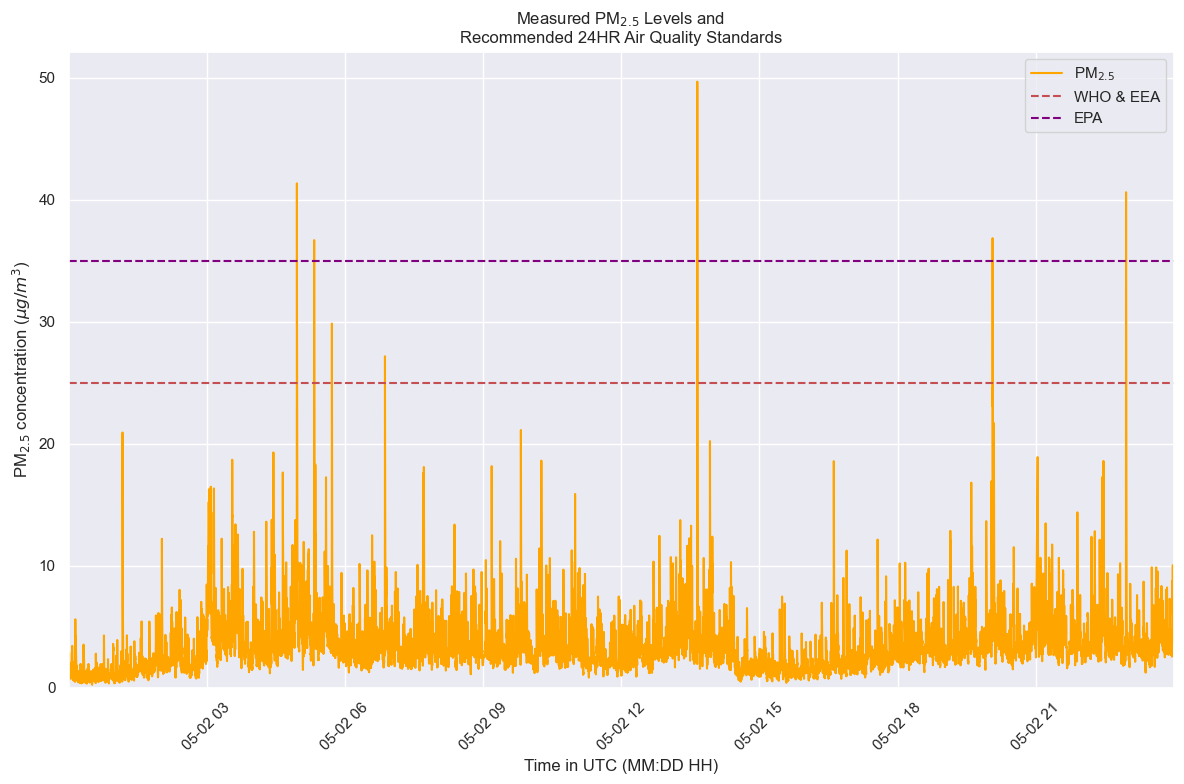

In [7]:
# | echo: false
#| output: true
plotPMwithAQS(ips_df, 'pm2_5')

In [8]:
def pmStats(df, pm_kind=None, time_range=None):
    ''' 
    Provide statistics about a desired PM concentration

    Args:
        pm dataframe, pm bin and time range to give stats over need to be added
    
    Returns:
        Nothing for now, prints a bunch of statements
    '''
    who_threshold = df[df['pm2_5'] > 25]
    above_threshold = [list(group) for group in mit.consecutive_groups(who_threshold.index)]
    print(f"Number of PM2.5 datapoints above the WHO recommended threshold: {len(who_threshold)}")
    print(f"Number of separate instances the threshold was crossed: {len(above_threshold)}")

    return len(who_threshold), len(above_threshold)

In [9]:
# num_points, num_crossed = pmStats(ips_df)

In [10]:
# from IPython.display import Markdown as md

# fr=2 #GHz

# md("$f_r = %i$ GHz"%(fr))

In [11]:
# md('Number of PM$_{2.5}$ datapoints above the WHO recommended threshold: %i'%(num_points))

In [12]:
#| echo: false
#| output: true
pmStats(ips_df)

Number of PM2.5 datapoints above the WHO recommended threshold: 88
Number of separate instances the threshold was crossed: 7


(88, 7)

# Demo: Showing distribution of PM

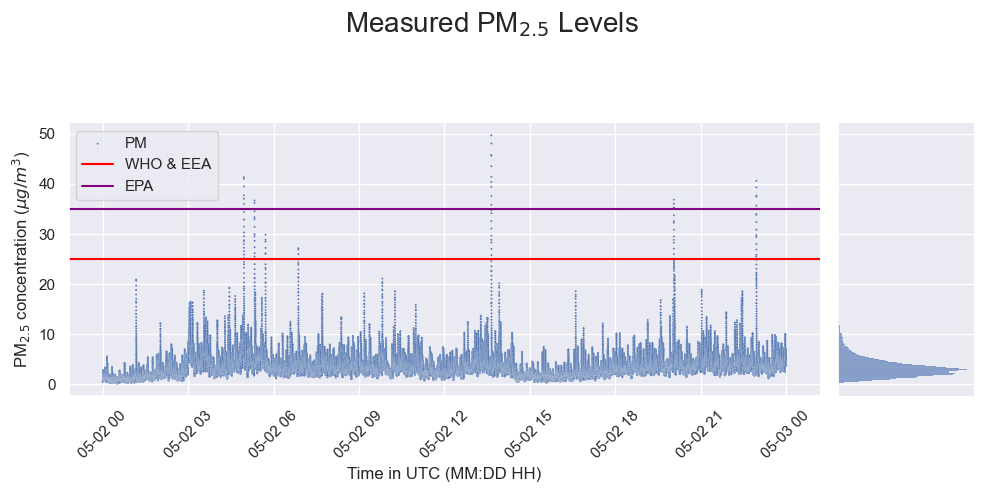

In [13]:
#| echo: false
#| output: true

g = sns.jointplot(data=ips_df, x='dateTime', y='pm2_5', s=2, ls='-.', label='PM')
g.ax_joint.axhline(y=25, color='red', label='WHO & EEA')
g.ax_joint.axhline(y=35, color='purple', label='EPA')
handles, labels = g.ax_joint.get_legend_handles_labels()
g.ax_joint.legend(handles=handles, labels=['PM', 'WHO & EEA','EPA',], title=None)
g.ax_marg_x.remove()
g.fig.set_size_inches((10, 5))
g.fig.suptitle(f'Measured {pm_labels["pm2_5"]} Levels', size=20)
g.set_axis_labels('Time in UTC (MM:DD HH)', f'{pm_labels["pm2_5"]} concentration ($\mu g/ m^3$)')
for tick in g.ax_joint.get_xticklabels():         
    tick.set_rotation(45)
plt.tight_layout()
# plt.subplots_adjust(hspace=0, wspace=0)
# plt.savefig(f"Plots/DUEDARE/{str(year)}/{plot_path}/PM Size/{name}/{name}.png")
plt.show()